# TR Data Challenge 2023 - Data Analysis

This notebook reads and analyzes the TRDataChallenge2023.txt file containing legal documents.

In [1]:
import json
import os
import pickle
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

## 1. Load the Data

In [2]:
def load_tr_data(file_path='/mnt/d/TR-Project/TRDataChallenge2023.txt'):
    """
    Load TR data from the text file.
    """
    documents = []
    
    print(f"Loading data from: {file_path}")
    file_size_mb = os.path.getsize(file_path) / (1024*1024)
    print(f"File size: {file_size_mb:.2f} MB")
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            if line.strip():
                try:
                    doc = json.loads(line.strip())
                    documents.append(doc)
                    
                    if (i + 1) % 5000 == 0:
                        print(f"Loaded {i + 1} lines...")
                        
                except json.JSONDecodeError:
                    continue
    
    print(f"Total documents loaded: {len(documents)}")
    return documents

# Load the data
documents = load_tr_data()

Loading data from: /mnt/d/TR-Project/TRDataChallenge2023.txt
File size: 321.03 MB
Loaded 5000 lines...
Loaded 10000 lines...
Loaded 15000 lines...
Total documents loaded: 18000


## 2. Explore Raw Data Structure

#### explore data structure in terminal before reading it</br>
```bash
head -n 1 TRDataChallenge2023.txt | python3 -m json.tool
```

In [3]:
# Examine the structure of the first document
if documents:
    print("Keys in first document:")
    print(list(documents[0].keys()))
    
    print("\nFirst document:")
    print(json.dumps(documents[0], indent=2)[:1000] + "...")  # Show first 1000 chars

Keys in first document:
['documentId', 'postures', 'sections']

First document:
{
  "documentId": "Ib4e590e0a55f11e8a5d58a2c8dcb28b5",
  "postures": [
    "On Appeal"
  ],
  "sections": [
    {
      "headtext": "",
      "paragraphs": [
        "Plaintiff Dwight Watson (\u201cHusband\u201d) appeals from the trial court\u2019s equitable distribution order entered 28 February 2017. On appeal, plaintiff contends that the trial court erred in its classification, valuation, and distribution of the parties\u2019 property and in granting defendant Gertha\u2009 Watson (\u201cWife\u201d) an unequal distribution of martial property. Because the trial court\u2019s findings of fact do not support its conclusions of law and because the distributional factors found by the trial court are based upon some of those erroneous findings and conclusions, we reverse the equitable distribution order and remand for entry of a new equitable distribution order."
      ]
    },
    {
      "headtext": "Backgrou

## 3. Convert to DataFrame

In [4]:
def create_dataframe(documents):
    """
    Convert documents to a pandas DataFrame.
    """
    data = []
    
    for doc in documents:
        # Basic document info
        row = {
            'document_id': doc.get('documentId', ''),
            'postures': ', '.join(doc.get('postures', [])),
            'num_postures': len(doc.get('postures', [])),
            'num_sections': len(doc.get('sections', [])),
        }
        
        # Extract text content
        all_text = []
        section_headers = []
        
        for section in doc.get('sections', []):
            header = section.get('headtext', '')
            if header:
                section_headers.append(header)
            
            paragraphs = section.get('paragraphs', [])
            all_text.extend(paragraphs)
        
        row['section_headers'] = ' | '.join(section_headers)
        row['full_text'] = ' '.join(all_text)
        row['text_length'] = len(row['full_text'])
        row['word_count'] = len(row['full_text'].split())
        row['num_paragraphs'] = len(all_text)
        row['num_headers'] = len(section_headers)
        
        data.append(row)
    
    return pd.DataFrame(data)

# Create DataFrame
df = create_dataframe(documents)
print(f"DataFrame shape: {df.shape}")
df.head(2)

DataFrame shape: (18000, 10)


,document_id,postures,num_postures,num_sections,section_headers,full_text,text_length,word_count,num_paragraphs,num_headers
0,Ib4e590e0a55f11e8a5d58a2c8dcb28b5,On Appeal,1,8,Background | Analysis | I. Classification issues | A. Cadillac El Dorado | B. Valuation of home ...,Plaintiff Dwight Watson (“Husband”) appeals from the trial court’s equitable distribution order ...,25583,4224,44,7
1,Ib06ab4d056a011e98c7a8e995225dbf9,"Appellate Review, Sentencing or Penalty Phase Motion or Objection",2,10,A. Offense Conduct | B. Prior Convictions | C. Guilty Plea | D. Sentencing | II. DISCUSSION | A....,"After pleading guilty, William Jerome Howard, Jr., appeals his 168-month sentence for possession...",18846,3004,29,9


In [5]:
from IPython.display import HTML, display

text = (
    "Examining the posture values in the dataframe reveals this is a classic "
    "multi-label classification problem. Each document can be assigned multiple "
    "posture labels simultaneously."
)

display(HTML(f'<span style="font-size: 150%;">{text}</span>'))

## 4. Data Analysis and Visualization

In [6]:
# Basic statistics
print("Dataset Overview:")
print(df.info())
print("\nDescriptive Statistics:")
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
print()
print(df.describe().round(2))
print()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   document_id      18000 non-null  object
 1   postures         18000 non-null  object
 2   num_postures     18000 non-null  int64 
 3   num_sections     18000 non-null  int64 
 4   section_headers  18000 non-null  object
 5   full_text        18000 non-null  object
 6   text_length      18000 non-null  int64 
 7   word_count       18000 non-null  int64 
 8   num_paragraphs   18000 non-null  int64 
 9   num_headers      18000 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 1.4+ MB
None

Descriptive Statistics:

       num_postures  num_sections  text_length  word_count  num_paragraphs  num_headers
count      18000.00      18000.00     18000.00    18000.00        18000.00     18000.00
mean           1.54          5.09     17986.55     2891.67           30.12  

### 4.1 Multi-Label Postures Distribution Analysis

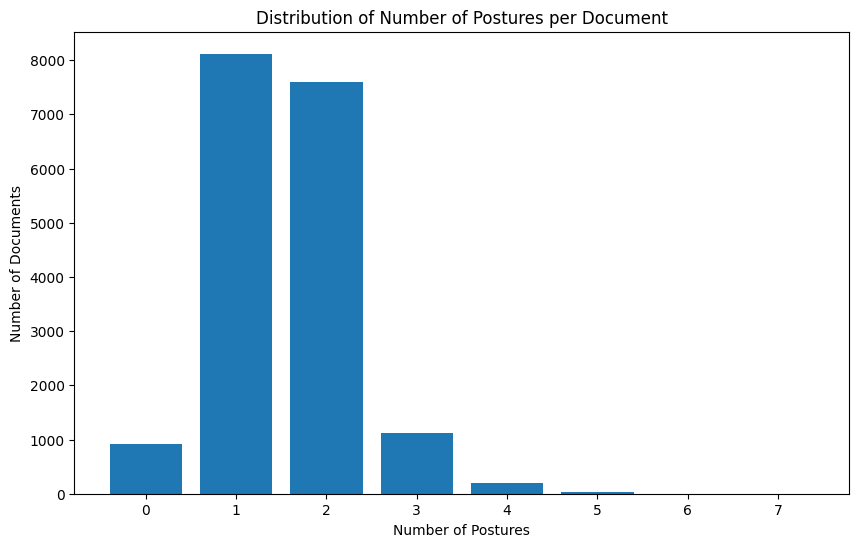

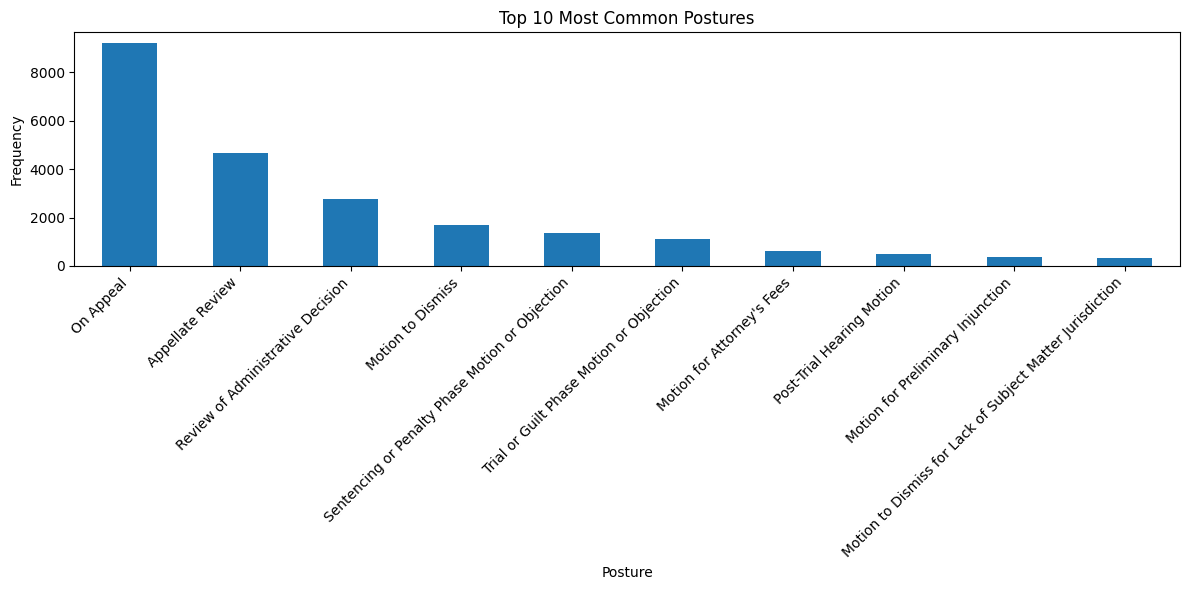

In [7]:
plt.figure(figsize=(10, 6))

# Count number of documents per number of postures
posture_counts = df['num_postures'].value_counts().sort_index()
plt.bar(posture_counts.index, posture_counts.values)
plt.title('Distribution of Number of Postures per Document')
plt.xlabel('Number of Postures')
plt.ylabel('Number of Documents')
plt.show()

# Most common postures
all_postures = []
for postures in df['postures']:
    if postures:
        all_postures.extend([p.strip() for p in postures.split(',')])

posture_freq = pd.Series(all_postures).value_counts().head(10)
plt.figure(figsize=(12, 6))
posture_freq.plot(kind='bar')
plt.title('Top 10 Most Common Postures')
plt.xlabel('Posture')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
_counts = df['num_postures'].value_counts(dropna=False)
_pct = df['num_postures'].value_counts(dropna=False,normalize=True) 

pd.DataFrame({
    'count': _counts,
    'percentage': _pct
}).sort_index().style.format({'count':'{:,}','percentage':'{:.2%}'}).set_caption("Distribution of num_postures")\
    .set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

,count,percentage
num_postures,,
0,923,5.13%
1,"8,118",45.10%
2,"7,604",42.24%
3,"1,129",6.27%
4,190,1.06%
5,32,0.18%
6,2,0.01%
7,2,0.01%


<span style="font-weight: bold; font-size: 18px;">**Multi-Label Posture Distribution Analysis**<br>

Based on the distribution charts examining posture frequency and prevalence patterns, the following key insights emerge:

**Label Distribution Characteristics:**

<div style="margin-left: 20px;"> • <strong>Modal Distribution:</strong> The majority of documents exhibit 1-2 posture labels, indicating a relatively sparse multi-label structure</div></br>

<div style="margin-left: 20px;"> • <strong>Label Complexity:</strong> Documents can contain up to 4+ concurrent posture labels, representing the complexity of multi-label density</div></br>

<div style="margin-left: 20px;"> • <strong>Unlabeled Data:</strong> Approximately 1,000 documents lack posture annotations (num_postures=0), requiring exclusion from the training dataset to prevent noise injection</div></br>

<div style="margin-left: 20px;"> • <strong>Severe Label Imbalance:</strong> "On Appeal" and "Appellate Review" dominate the dataset as the most prevalent posture labels, while numerous categories exhibit extremely low frequency, creating a highly imbalanced multi-label distribution that poses significant challenges for model training</div></br>

<div style="margin-left: 20px;"> • <strong>Class Imbalance Mitigation Strategies:</strong> </br>

The substantial disparity between dominant and rare categories necessitates implementation of specialized techniques such as:</br>

  <div style="margin-left: 40px;">- Undersampling of overrepresented classes</div></br>

  <div style="margin-left: 40px;">- Class-weighted loss functions to amplify learning signals from minority categories</div></br>

  <div style="margin-left: 40px;">- Focal loss or other imbalance-aware optimization approaches</div></br>

</div>

<div style="margin-left: 20px;"> • <strong>Training Implications:</strong> Without proper handling of this imbalance, the model may develop bias toward frequent categories while failing to adequately learn rare but potentially important legal postures</div>

**Data Quality Implications:**
The identified unlabeled instances necessitate data preprocessing to ensure training dataset integrity and model performance optimization.

</span>

In [9]:
# Prepare the labels - convert postures to a list format
def prepare_labels(postures_str):
    """Convert posture string to list of postures"""
    if pd.isna(postures_str) or postures_str == '':
        return []
    return [p.strip() for p in postures_str.split(',') if p.strip()]

df['posture_list'] = df['postures'].apply(prepare_labels)

# Remove documents with no postures
df_temp = df[df['posture_list'].apply(len) > 0].copy()
print("{:<30}{:<20,}".format("Documents with postures: ", len(df_temp)))
print("{:<30}{:<20}".format("Documents without postures: ", len(df)-len(df_temp)))

Documents with postures:      17,077              
Documents without postures:   923                 


In [10]:
# Analyze posture distribution
all_postures_ml = []
for postures in df_temp['posture_list']:
    all_postures_ml.extend(postures)

posture_counts = pd.Series(all_postures_ml).value_counts()
print(f"\nTotal unique postures: {len(posture_counts)}")
print()
print(f"Most common postures:")
print(posture_counts.head(15))


Total unique postures: 230

Most common postures:
On Appeal                                                         9197
Appellate Review                                                  4652
Review of Administrative Decision                                 2773
Motion to Dismiss                                                 1679
Sentencing or Penalty Phase Motion or Objection                   1342
Trial or Guilt Phase Motion or Objection                          1097
Motion for Attorney's Fees                                         612
Post-Trial Hearing Motion                                          512
Motion for Preliminary Injunction                                  364
Motion to Dismiss for Lack of Subject Matter Jurisdiction          343
Motion to Compel Arbitration                                       255
Motion for New Trial                                               226
Petition to Terminate Parental Rights                              219
Motion for Judgment as a M

In [11]:
# Filter to most common postures (those appearing in at least 100 documents)
min_frequency = 100
common_postures = posture_counts[posture_counts >= min_frequency].index.tolist()
print(f"\nPostures with >= {min_frequency} occurrences: {len(common_postures)}")
print(common_postures)


Postures with >= 100 occurrences: 27
['On Appeal', 'Appellate Review', 'Review of Administrative Decision', 'Motion to Dismiss', 'Sentencing or Penalty Phase Motion or Objection', 'Trial or Guilt Phase Motion or Objection', "Motion for Attorney's Fees", 'Post-Trial Hearing Motion', 'Motion for Preliminary Injunction', 'Motion to Dismiss for Lack of Subject Matter Jurisdiction', 'Motion to Compel Arbitration', 'Motion for New Trial', 'Petition to Terminate Parental Rights', 'Motion for Judgment as a Matter of Law (JMOL)/Directed Verdict', 'Motion for Reconsideration', 'Motion to Dismiss for Lack of Personal Jurisdiction', 'Motion for Costs', 'Juvenile Delinquency Proceeding', 'Motion for Default Judgment/Order of Default', 'Motion to Dismiss for Lack of Standing', 'Motion to Dismiss for Lack of Jurisdiction', 'Motion to Transfer or Change Venue', 'Petition for Divorce or Dissolution', 'Motion for Contempt', 'Motion for Protective Order', 'Motion for Permanent Injunction', 'Motion to Se

In [12]:
# Filter documents to only include those with common postures
def filter_common_postures(posture_list, common_postures):
    """Keep only postures that are in the common_postures list"""
    return [p for p in posture_list if p in common_postures]

df_temp['filtered_postures'] = df_temp['posture_list'].apply(
    lambda x: filter_common_postures(x, common_postures)
)

# Remove documents that have no common postures after filtering
df_ml = df_temp[df_temp['filtered_postures'].apply(len) > 0].copy()
print(f"Documents after filtering to common postures: {len(df_ml)}")

Documents after filtering to common postures: 16568


In [13]:
unique_postures_raw = len(set(itertools.chain.from_iterable(df['posture_list'])))
unique_postures_temp = len(set(itertools.chain.from_iterable(df_temp['posture_list'])))
unique_postures_ml = len(set(itertools.chain.from_iterable(df_ml['filtered_postures'])))

pd.DataFrame({
    "--": ["raw_document", "Removing Missing Postures", "Filter to Common Postures"],
    "sample size": [df.shape[0], df_temp.shape[0], df_ml.shape[0]],
    "Total unique postures": [unique_postures_raw, unique_postures_temp, unique_postures_ml]
}).style.format({'sample size':'{:,}'})

,--,sample size,Total unique postures
0,raw_document,"18,000",230
1,Removing Missing Postures,"17,077",230
2,Filter to Common Postures,"16,568",27


### 4.2 Text Length Distribution Analysis

<span style="color: red; font-weight: bold; font-size: 18px;"> **Text Length Analysis for Model Selection and Optimization**</br>

Analyzing text length distribution is a critical preprocessing step that directly influences model architecture selection and performance optimization. When deploying Large Language Models (LLMs) for this multi-label classification task, context length becomes a pivotal consideration due to several key factors:

**Context Length Constraints:** </br>Each LLM architecture has a predefined maximum context length (e.g., 512 tokens for BERT, 4096 for Longformer, 8192 for MordernBERT, 10000+ for many decoder models(Llama, Mistral, Qwen family etc)). Understanding our data's text length distribution enables informed model selection that balances computational efficiency with information preservation.

**Resource Optimization:**</br> Oversized context windows lead to unnecessary computational overhead and increased memory consumption without performance gains. Conversely, insufficient context length results in critical information truncation, potentially degrading model accuracy.

**Strategic Implications:** </br>By examining the statistical distribution of text lengths across our dataset, we can:

Select appropriate model architectures with optimal context lengths
Implement efficient text preprocessing strategies (chunking, summarization, or truncation)
Estimate computational requirements and training costs
Ensure minimal information loss during model input preparation
This analysis forms the foundation for making data-driven decisions regarding model selection and hyperparameter configuration. </span>

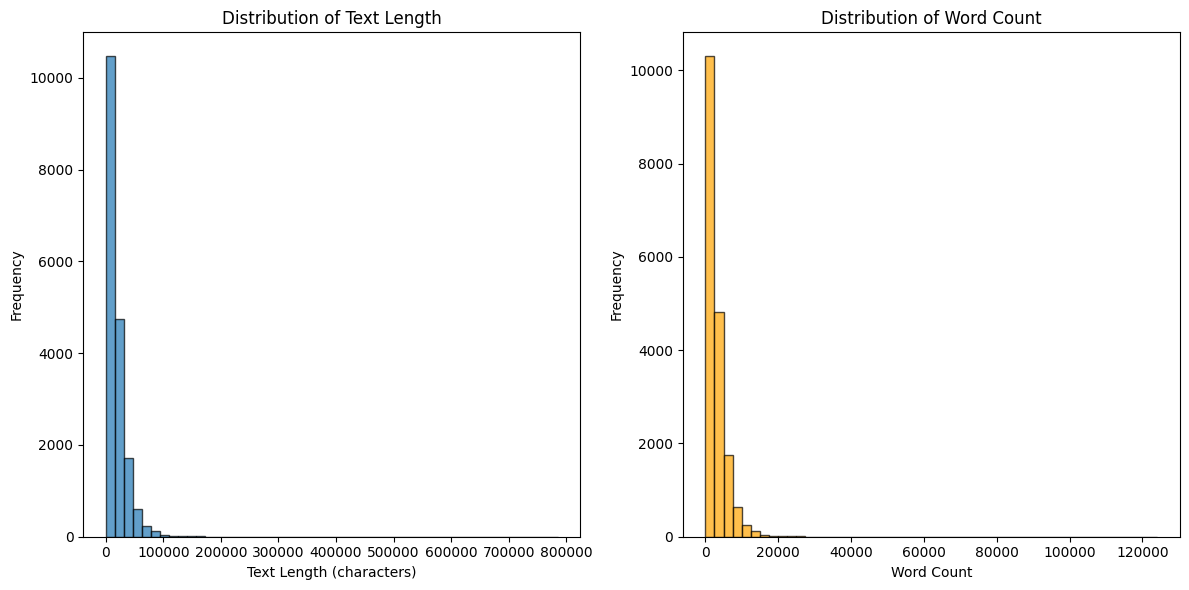

In [14]:
# Text length distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['word_count'], bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<span style="font-weight: bold; font-size: 18px;"> **Accurate Text Length Measurement Using Subword Tokenization**</br>

The initial text length analysis employed a basic word-counting approach using whitespace as delimiters. However, this naive methodology fails to accurately represent how Large Language Models process and interpret textual input, leading to potential misestimation of context requirements.

**Tokenization Discrepancy:**</br> LLMs do not process text at the word level as humans do. Instead, they utilize sophisticated subword tokenization algorithms including:

<div style="margin-left: 20px;">1. Byte Pair Encoding (BPE): Used by GPT models</div>
<div style="margin-left: 20px;">2. WordPiece: Employed by BERT variants</div>
<div style="margin-left: 20px;">3. SentencePiece: Utilized by T5 and many multilingual models</div>

**Technical Implementation:**</br> To obtain precise context length measurements that align with actual LLM processing, we implement tokenization using ModernBERT, which employs BPE (Byte Pair Encoding) for subword segmentation. This approach provides several advantages:

<div style="margin-left: 20px;">1. Accurate Token Counting: Measures text length in the same units that the model processes</div>
<div style="margin-left: 20px;">2. Context Window Optimization: Enables precise estimation of how much text fits within model constraints</div>
<div style="margin-left: 20px;">3. Model-Agnostic Approach: The methodology can be adapted for different tokenizers (e.g., GPT-2/3/4 or many other LLMs' tokenizer) based on target model selection</div>


</span>

### text length distribution using subword tokenization

In [15]:
from transformers import AutoTokenizer
model_path = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_path)


In [16]:
from datasets import Dataset
# text_df=df["full_text"].to_frame("text")
text_df=df_ml.loc[:,["full_text","postures"]]
hf=Dataset.from_pandas(text_df)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
hf=hf.map(lambda x: tokenizer(x["full_text"]),batched=True)
hf=hf.map(compute_lenth)
df0=hf.to_pandas()

Map:   0%|          | 0/16568 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (10760 > 8192). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/16568 [00:00<?, ? examples/s]

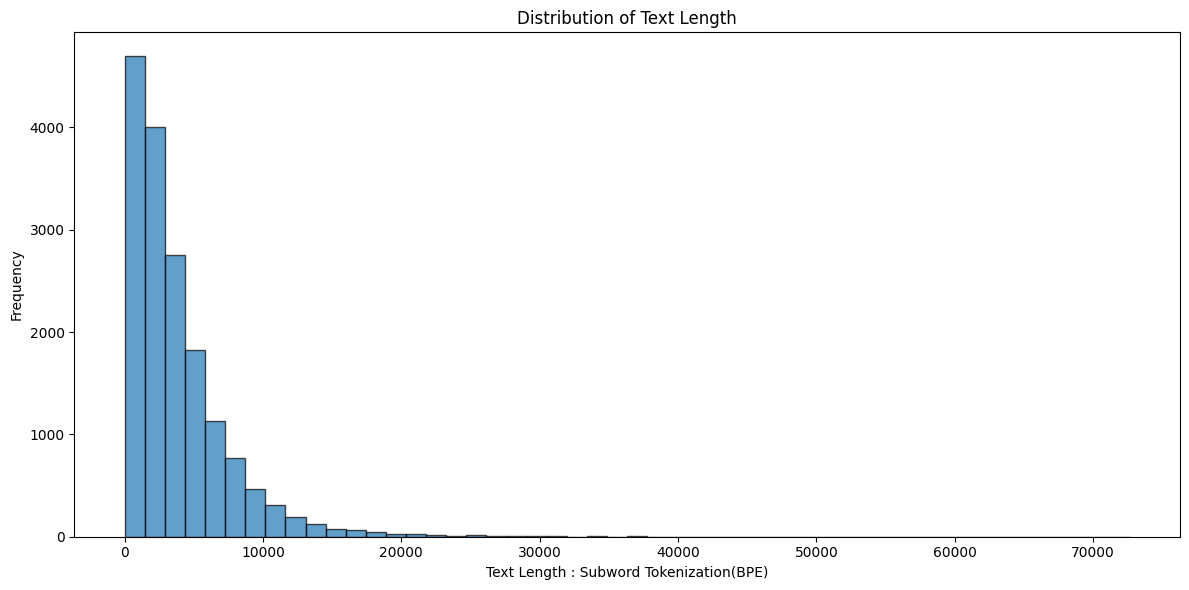

In [17]:
# Text length distribution
plt.figure(figsize=(12, 6))

plt.hist(df0['text_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length : Subword Tokenization(BPE)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<span style="font-weight: bold; font-size: 18px;">**Subword Tokenization Analysis Results and Model Selection**</br>

The subword tokenization analysis reveals that the average text length across the corpus is 3,826 tokens. When considering ModernBERT as our target language model, which supports a maximum context length of 8,192 tokens, this configuration provides excellent coverage for our dataset.

Key Findings:

<div style="margin-left: 20px;"> •  Average token length: 3,826 tokens per document</div>
<div style="margin-left: 20px;"> •  Model capacity: ModernBERT's 8,192-token context window</div>
<div style="margin-left: 20px;"> •  Coverage efficiency: Approximately 90% of documents (up to 8,143 tokens) can be processed without truncation</div>


</span>

## 5. split the data into training, validation and test set

In [18]:
## Multi-label Classification Setup

# Create binary label matrix using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_multilabel = mlb.fit_transform(df_ml['filtered_postures'])

print(f"Label matrix shape: {y_multilabel.shape}")
print(f"Labels: {mlb.classes_}")

Label matrix shape: (16568, 27)
Labels: ['Appellate Review' 'Juvenile Delinquency Proceeding'
 "Motion for Attorney's Fees" 'Motion for Contempt' 'Motion for Costs'
 'Motion for Default Judgment/Order of Default'
 'Motion for Judgment as a Matter of Law (JMOL)/Directed Verdict'
 'Motion for New Trial' 'Motion for Permanent Injunction'
 'Motion for Preliminary Injunction' 'Motion for Protective Order'
 'Motion for Reconsideration' 'Motion to Compel Arbitration'
 'Motion to Dismiss' 'Motion to Dismiss for Lack of Jurisdiction'
 'Motion to Dismiss for Lack of Personal Jurisdiction'
 'Motion to Dismiss for Lack of Standing'
 'Motion to Dismiss for Lack of Subject Matter Jurisdiction'
 'Motion to Set Aside or Vacate' 'Motion to Transfer or Change Venue'
 'On Appeal' 'Petition for Divorce or Dissolution'
 'Petition to Terminate Parental Rights' 'Post-Trial Hearing Motion'
 'Review of Administrative Decision'
 'Sentencing or Penalty Phase Motion or Objection'
 'Trial or Guilt Phase Motion or 

In [19]:
# Prepare text data
X_text = df_ml['full_text'].values

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_text, y_multilabel, 
    test_size=0.3, # 30% for temp (which will be split into val and test)
    random_state=42, 
    stratify=None
)

 # Split temp into validation and test (50-50 split of the 30%)
# # This gives us 15% each
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42, 
    stratify=None
)

print("{:<18}{:<10,}{:<15.0%}".format("Total samples:",len(df_ml),1))
print("{:<18}{:<10,}{:<15.0%}".format("Training set:",len(X_train),len(X_train)/len(df_ml)))
print("{:<18}{:<10,}{:<15.0%}".format("Validation set:",len(X_val),len(X_val)/len(df_ml)))
print("{:<18}{:<10,}{:<15.0%}".format("Test set:",len(X_test),len(X_test)/len(df_ml)))

Total samples:    16,568    100%           
Training set:     11,597    70%            
Validation set:   2,485     15%            
Test set:         2,486     15%            


In [20]:
# Check label distribution
train_label_sums = y_train.sum(axis=0)
val_label_sums = y_val.sum(axis=0)
test_label_sums = y_test.sum(axis=0)

print("\nLabel distribution in training set:")
print()
for i, label in enumerate(mlb.classes_):
    print(f"{label}: {train_label_sums[i]} ({train_label_sums[i]/len(y_train)*100:.1f}%)")


Label distribution in training set:

Appellate Review: 3310 (28.5%)
Juvenile Delinquency Proceeding: 103 (0.9%)
Motion for Attorney's Fees: 412 (3.6%)
Motion for Contempt: 88 (0.8%)
Motion for Costs: 121 (1.0%)
Motion for Default Judgment/Order of Default: 101 (0.9%)
Motion for Judgment as a Matter of Law (JMOL)/Directed Verdict: 147 (1.3%)
Motion for New Trial: 156 (1.3%)
Motion for Permanent Injunction: 73 (0.6%)
Motion for Preliminary Injunction: 254 (2.2%)
Motion for Protective Order: 73 (0.6%)
Motion for Reconsideration: 145 (1.3%)
Motion to Compel Arbitration: 179 (1.5%)
Motion to Dismiss: 1155 (10.0%)
Motion to Dismiss for Lack of Jurisdiction: 82 (0.7%)
Motion to Dismiss for Lack of Personal Jurisdiction: 138 (1.2%)
Motion to Dismiss for Lack of Standing: 87 (0.8%)
Motion to Dismiss for Lack of Subject Matter Jurisdiction: 231 (2.0%)
Motion to Set Aside or Vacate: 73 (0.6%)
Motion to Transfer or Change Venue: 88 (0.8%)
On Appeal: 6404 (55.2%)
Petition for Divorce or Dissolutio

In [21]:
# Check label distribution
def label_dist(y_train, data_split="training"):
    train_label_sums = y_train.sum(axis=0)

    # Get top 5 most frequent labels and their indices
    top5_indices = train_label_sums.argsort()[-5:][::-1]
    top5_labels = [mlb.classes_[i] for i in top5_indices]
    top5_counts = train_label_sums[top5_indices]

    print(f"\nTop 5 most frequent labels in {data_split} set:")
    print()
    for idx, label in zip(top5_indices, top5_labels):
        count = train_label_sums[idx]
        percent = count / len(y_train) 
        # print(f"{label}: {count} ({percent:.1f}%)")
        print("{:<50}{:<10,}{:<15.1%}".format(f"{label}:", count, percent))

In [22]:
label_dist(y_train, data_split="training")


Top 5 most frequent labels in training set:

On Appeal:                                        6,404     55.2%          
Appellate Review:                                 3,310     28.5%          
Review of Administrative Decision:                1,940     16.7%          
Motion to Dismiss:                                1,155     10.0%          
Sentencing or Penalty Phase Motion or Objection:  953       8.2%           


In [23]:
label_dist(y_val, data_split="validation")


Top 5 most frequent labels in validation set:

On Appeal:                                        1,381     55.6%          
Appellate Review:                                 679       27.3%          
Review of Administrative Decision:                406       16.3%          
Motion to Dismiss:                                255       10.3%          
Sentencing or Penalty Phase Motion or Objection:  204       8.2%           


In [24]:
label_dist(y_test, data_split="test")


Top 5 most frequent labels in test set:

On Appeal:                                        1,412     56.8%          
Appellate Review:                                 663       26.7%          
Review of Administrative Decision:                427       17.2%          
Motion to Dismiss:                                269       10.8%          
Sentencing or Penalty Phase Motion or Objection:  185       7.4%           


## 6. Save Preprocess Data

In [25]:
## save preprocess data
saved_data=os.path.join(os.getcwd(), 'processed_data')
os.makedirs(saved_data, exist_ok=True)
# Save using pickle
with open(os.path.join(saved_data,'train_arrays.pkl'), 'wb') as f:
    pickle.dump({'X_train': X_train, 'y_train': y_train}, f)

with open(os.path.join(saved_data,'val_arrays.pkl'), 'wb') as f:
    pickle.dump({'X_val': X_val, 'y_val': y_val}, f)

with open(os.path.join(saved_data,'test_arrays.pkl'), 'wb') as f:
    pickle.dump({'X_test': X_test, 'y_test': y_test}, f)

with open(os.path.join(saved_data,'class_name.pkl'), 'wb') as f:
    pickle.dump({'class_name': mlb.classes_}, f)

print("All arrays saved with pickle!")

# To load later:
# with open(os.path.join(saved_data,'train_arrays.pkl'), 'rb') as f:
#     train_data = pickle.load(f)
#     X_train = train_data['X_train']
#     y_train = train_data['y_train']
#     label_train = train_data['label_train']

All arrays saved with pickle!
